# Notebook for building the Sagehen model with Gsflow-Arcpy

### Background
This notebook runs the scripts for building the Saghen GSFLOW model.
Requires Python 2.7 or newer, ArcMap, and the data/python scripts provided in the develop branch of the repository located here: https://github.com/gsflow/gsflow-arcpy. Documentation can be found in the tutorial file called gsflow_arcpy_tutorial.pdf located in the gsflow-arcpy repository. 

The primary reference for these scripts is:

Gardner, M. A., Morton, C. G., Huntington, J. L., Niswonger, R. G., & Henson, W. R. (2018). Input data processing tools for the integrated hydrologic model GSFLOW. Environmental Modelling & Software, 109, 41-53. https://doi.org/10.1016/j.envsoft.2018.07.020

If the gsflow-arcpy scripts are taken from the Github repositor then a slight modificatioin is required to "fishnet_generator.py" to remove the need for user input at the command prompt. Within fishnet_func, the argument "overwrite_flag" must be set to "True." However, this change has been made for the scripts provided for this class.

Note that the hru_params shapefile cannot be open in ArcMap while running some of these scripts.

Before using this notebook you will need to change paths in the gsflow-arcpy scripts configuration file. Navigate to: .\gsflowID2447_classrepo\exercises\saghen_prms. Open “sagehen_parameters.ini” in a text editor. Replace first part of filepaths by globally replacing “C:\Users\rniswon\Documents\Data\Git\“ using the correct path for your computer.


In [1]:
import matplotlib as mpl
mpl.__version__

#C:\Python27\ArcGIS10.5>C:\Python27\ArcGIS10.5\Scripts\pip.exe install matplotlib --upgrade

'2.0.0b3'

In [2]:
%matplotlib inline
import sys, os
import matplotlib.pyplot as plt
import arcpy
import geopandas
from pyprms import prms_py
from pyprms.prms_output import Statistics, Budget
python_exe = sys.executable
print python_exe

C:\Users\rniswon\AppData\Local\Continuum\miniconda2\python.exe


### Required ancillary data
Geospatial and other ancillary data are required to run these scripts. These data include: elevation data such as a digital elevation model (DEM); subbasin outflow points or subbasin stream gages that can be used for defining subbasin drainage areas; gridded climate data such as the PRISM 800 m monthly normals; vegetation data such as the LANDFIRE dataset; impervious cover such as the National Land Cover Database (NLCD); soil data such as STATSGO and/or SSURGO datasets. Other datasets such as geology, and the National Hydrography Dataset (NHD) can be used. All of the necessary geospatial data required for this exercise are included with the Sagehen example problem in the above noted repository.

This exercise begins with two shapefiles, including the model upstream boundary and outflow point. Because all areas in the Sagehen Creek Watershed drain to a single outflow point, a model boundary can be created using the Arc Watershed tool. However, both the outflow point and model boundary already exist in the directory .\Exercise_2\examples\sagehen\shapefiles.

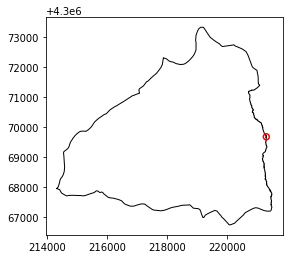

In [19]:
fn1=r"C:\Users\rniswon\Documents\Data\Git\gsflowID2447_classrepo\exercises\saghen_prms\examples\sagehen\shapefiles\watershed.shp"
os.path.isfile(fn1)
hru=geopandas.read_file(fn1)
fn2=r"C:\Users\rniswon\Documents\Data\Git\gsflowID2447_classrepo\exercises\saghen_prms\examples\sagehen\shapefiles\model_points.shp"
gage=geopandas.read_file(fn2)
gage.plot(ax=hru.plot(color='none', edgecolor='black', linewidth=1.0), color='none', edgecolor='red')

### Executing GSFLOW-Arcpy
To the run the scripts from this notebook, first set the file path for the location of the scripts,  set the argument list, and set the file path for the configuration file (sagehen_parameters.ini). The paths below will need to be replaced with your computer's corresponding path.

In [5]:
arc_gsflow_folder=r"D:\gsflowID2447_classrepo.git\exercises\saghen_prms\scripts"
script = r"fishnet_generator.py"
argument = r" -i D:\gsflowID2447_classrepo.git\exercises\saghen_prms\examples\sagehen\sagehen_parameters.ini"

Combine the above variables to create the command that runs the script.

In [6]:
cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument

### HRU_params shapefile and model grid

The model grid that is used for representing HRUs and MODFLOW cells is generated by running the "fishnet_generator.py:"

In [8]:
os.system(cmd)

0

Below is an image showing the 90 m square model grid used for the Sagehen model.

<img src="./captures/sagehen_fishnet.png" style="float: center" width="400">

Run "hru_parameters.py" to create the hru_params shapefile and label all attribute fields required for the model. This script also sets HRU_type, which defines the active part of the model domain for PRMS using the model boundary shapefile shown above, and also defines subbasin and model outlets or swales using the model points shapefile.


In [9]:
script = r"hru_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument

In [10]:
os.system(cmd)

0

The image below shows the attribute table generated by running hru_parameters.py. This table is in the hru_params shapefile generated by the script. The shapefile must be closed while running any script, but can be re-opened after each script is run to check values and raster images.

<img src=".\captures\sagehen_attribute.png" style="float: center" width="800">

### Resample DEM to model grid
The next script is DEM_parameters.py. This script generates grid-cell altitudes by resampling the DEM to the fishnet. Among the several fields in HRU_params that are given values when running this script, the field called DEM_ADJ is used to represent the model top altitudes. Other parameters are derived from DEM_ADj including the cascade parameters. The attribute DEM_FLOWAC is the default field that holds the original DEM_ADJ values as a backup and to provide a comparison after CRT is run. 

In [11]:
script = r"dem_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument

In [12]:
os.system(cmd)

0

The image below shows the DEM_ADJ attribute generated by the script dem_parameters.py. DEM_ADJ is used to define grid cell altitudes for the top of the model, and these values will eventually be read into the PRMS parameter files.

<img src=".\captures\sagehen_dem_adj.png" style="float: center" width="400">

### Stream network
Now it is time to build the stream network for the model. This is done by running the script called "dem_2_streams.py." The results of this script will be used to develop input for the MODFLOW SFR Package. 

In [13]:
script = r"dem_2_streams.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

Running dem_2_streams.py also generates a shape file of the streams as lines for plotting. If you open Arcmap and add the streams.shp file located in .\Exercise_2\examples\sagehen\hru_params\flow_rasters then you can see the stream lines in the watershed as shown below. Note that these streams are developed using the model grid scale DEM (DEM_ADJ) rather than the original 10 m DEM. This is an important feature of the scripts because GSFLOW simulates SW-GW interactions using the stream depth and groundwater head. If the streams are generated using the 10 m DEM then streams can be shifted relative to the stream canyons represented by the model grid scale altitudes (90 m DEM). Shifted streams will cause poor convergence, erroneous stream seepage, and excessive spring discharge in cells adjacent to streams. 

<img src=".\captures\sagehen_streams.png" style="float: center" width="400">

Resolution of the stream network is determined using two parameters that are set in the Gsflow-Arcpy scripts configuration file (sagehen_parameters.ini). These are flow_acc_threshold and flow_length_threshold. The NHD streams data set also is provided in this example in .\Exercise_2\examples\sagehen\nhd. 

Exercise: determine the values of flow_acc_threshold and flow_length_threshold that provide a stream network most similar to the NHD streams. Note the example problem uses flow_acc_threshold=100 and flow_length_threshold=3, which produces less streams than NHD to be more consistent with flowing streams at Saghen Creek.

Question: Why don't the streams created using the script align perfectly with the NHD streams? What could happen if the NHD streams were used directly to define SFR streams?

<img src=".\captures\sagehen_streams+nhd.png" style="float: center" width="400">

### PRMS cascade routing parameters
"crt_fill_parameters.py" runs the Cascade Routing tool (https://water.usgs.gov/ogw/CRT/) with no designated streams, because CRT does not fill cells that contain streams. By excluding streams, cells containing streams will be filled if they are undeclared swales. CRT fills swales for cells to create downward sloping paths from every cell inside the watershed boundary. Swales are HRUs/cells that are surrounded in all 4 or 8 directions by cells of higher elevation. Streams and stream cells must slope downard in the direction of flow. Non-stream cells can be designated as swales, but caution should be used as no lateral flow can occur out of a swale. Also, note that there cannot be swales for cascades used for routing flow through PRMS groundwater flow reservoirs (GWRs). A swale cell (in the case of an endorheic basin or the like) would need the HRU id of a nearby cell to use for its GWR.

In [15]:
script = r"crt_fill_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

To re-build streams with the CRT filled elevations, re-run "dem_2_streams.py" again. Then re-run "crt_fill_parameters.py" as good practice to ensure no undecared swales exist.

The "stream_parameters.py" script runs CRT again, while this time including the streams, such that cascade paths will end at HRUs that contain streams. The PRMS cascade routing parameters and SFR Package stream reach information are generated.

In [16]:
script = r"stream_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

A note about CRT: it developes the cascade routing parameters for PRMS. Cascades are pre-defined routing directions for overland flow and subsurface storm flow simulated by PRMS. CRT can develop cascades as 4-way (cell faces) or 8-way (cell faces and diagonals), and in this case we are using the 8-way option. The assumption is that the watershed slopes are steep enough to assume the water surface slope is equal to land surface slope, which is often a reasonable approximation. Note, this is the same approximation made in the SFR Package. Thus, if there is water stored on the surface or in the gravity storage reservoir of the soil zone then water will be routed according to the directions defined by the cascade paths.

After running the "stream_parameters.py" we can visualize cascades. This can be done by using the Cascade Routing Visualization tool (CRV). 

1) Open Arc and set the default coordinate system by choosing “Geoprocessing” menu, “Environments” “Output Coordinates.” Set the coordinate system by choosing another shape file from this project (e.g., hru_params.shp). Arc will also assume the coordinate system of the first file opened in a new map project.

2) Add the CRV tool box by right clicking in the ArcToobox window; navigate to the hru_params folder->cascade_work->CRV_1 and select CRV_1.gdb.

3) Double click the CRV tool, navigate and select the folder (workspace) .\Exercise_2\examples\sagehen\hru_params\cascade_work, select ok and run the tool.

The results are shown below. 



<img src=".\captures\sagehen_cascades.png" style="float: center" width="400">

And zooming in:
    <img src=".\captures\sagehen_cascades_close.png" style="float: center" width="400">

### Vegetation parameters
"veg_parameters.py" creates all PRMS parameters that characterize vegetation in the model using the LANDFIRE vegetation dataset. These parameters represent cover type, winter and summer cover density, winter and summer interception (snow and rain), and root depth.  

In [17]:
script = r"veg_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

PRMS represents four cover types: 1=grasses, 2=shrubs, 3= deciduous trees, 4=coniferous trees. Although there are many types of vegetation that are classified in LANDFIRE, these types are "remapped" to one of the four types represented in PRMS. 

   Here is a Google Earth image showing vegetation cover in the watershed:
   <img src=".\captures\sagehen_GE_veg.png" style="float: center" width="500">

Below is the cell/HRU resampled from LANDFIRE winter cover density.
 <img src=".\captures\sagehen_veg_wdensity.png" style="float: center" width="600">

 Below is the vegetation type map for PRMS. As you can see the area is primarily covered with conifers and some shrubs and deciduous (riparian) trees along streams.
 <img src=".\captures\sagehen_veg_cover.png" style="float: center" width="600">

### PRMS Soilzone parameters
The "soil_raster_prep.py" script is run to prepare the soil rasters, such as clipping to the grid and filling missing data in the soil data set.

In [18]:
script = r"soil_raster_prep.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

"soil_parameters.py" uses the prepared soil rasters to develop maps of soil texture, available water holding capacity, and the saturated hydraulic conductivity (Ksat). These values are used to develop PRMS soilzone parameters. 

In [19]:
script = r"soil_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

 The distribution of Ksat provided by the SSURGO data is shown below.
 <img src=".\captures\sagehen_Ksat.png" style="float: center" width="600">

The PRMS parameter slowcoef_lin is derived from Ksat. The Ksat and soil texture data distributions are combined to generate the spatial variablity of the PRMS soilzone parameters.

Among the several PRMS soilzone parameters that are calculated by soil_parameters.py, slowcoef_lin is shown below.
 <img src=".\captures\sagehen_slowceof_lin.png" style="float: center" width="600">

### PRMS climate input
Daily climate for each grid cell/HRU is required for GSFLOW. A good approach for generating daily climate for each cell/HRU in the model is to rely on climate stations for the daily values (Tmin, Tmax, and PPT). Monthly average spatial adjustment factors are then used to distribute the climate station data to all cells/HRUs. For temperature, either the Temp_1sta or Temp_lapse module is used. For Temp_1sta, temperature adjustment factors by month and cell/HRU are calculated using the monthly PRISM 30-year normals; for Temp_lapse, two climate stations are used to distribute temperatures according to altitude. The latter approach is preferred if there is a low and high altitude station within or near the subbasin. The default approach for the prism_parameters.py script is Temp_1sta, and this can be changed to Temp_lapse in the configuration (.ini) file. Similarly, the Precip_1sta module is default and spatial adjustment factors are calculated using the monthly PRISM 30-year normals.

PRMS can read daily climate grids directly, and you may be asking why the dialy PRISM or other gridded climate data is not input directly to the model. The reason is that for basin scale models, the daily climate grids take up huge amounts of disc space, and slow the model significantly to read these data sets for each model time step. Tests have shown that the station-based climate distribution is as good, or better than daily gridded climate products, and there is a 10% or more speed up in model performance.   

"prism_parameters.py" uses ArcMap's zonal statistic tool to resample PRISM 800 m of PRISM 4 km climate data to each cell/HRU. These values will be used to calculate the climate adjustment factors for PRMS. 

In [20]:
script = r"prism_800m_normals.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

The cell/HRU resampled PRISM climate is then used with climate station statistics to calculate precipitation and temperature adjustment factors for each month and cell/HRU.

In [21]:
script = r"ppt_ratio_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

The monthly average precipitation (mm) for January is shown below. For days in January, the daily precipitation measured at the climate station will be multiplied by the adjustment factors to calculate precipitation at each cell/HRU.
 <img src=".\captures\sagehen_precip_ratio.png" style="float: center" width="600">


In [22]:
script = r"impervious_parameters.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

Impervious area maps provided by NLCD are used to assign impervious percentages to each cell/RHU using "impervious_parameters.py." Below you can see that other than a few roads, there is no impervious area in Sagehen Creek Watershed.
<img src=".\captures\sagehen_impervious_pct.png" style="float: center" width="600">

Now that we have all the required data for building a PRMS model, we can build the PRMS input files. It's good practice to observe/edit the parameter and dimension CSV files that hold model specific settings before building the parameter files.

In [23]:
script = r"prms_template_fill.py"

cmd=python_exe + " " + os.path.join(arc_gsflow_folder,script)
cmd = cmd + argument
os.system(cmd)

0

Now we can run GSFLOW. Replace the paths below with the correct paths for your working directory. 

In [4]:
gsflow_folder=r"D:\gsflowID2447_classrepo.git\exercises\saghen_prms\examples\sagehen\model\bin"
gsflow = r"gsflow.exe"
argument = r" D:\gsflowID2447_classrepo.git\exercises\saghen_prms\examples\sagehen\model\windows\sagehen_run.control"
cmd=os.path.join(gsflow_folder,gsflow)
cmd = cmd + argument
os.system(cmd)

0

After running the model we can plot of the simulated streamflow. In order to read in the PRMS results (statvar output) we use a python script developed by Ayman Alzraiee from the California Water Science Center. 

In [5]:
cname = r"D:\gsflowID2447_classrepo.git\exercises\saghen_prms\examples\sagehen\model\windows\sagehen.control"
prms = prms_py.Prms_base()
prms.control_file_name = cname
prms.load_prms_project()
stat=Statistics(prms)
tt=stat.stat_dict['basin_cfs_0'][1]
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.xlabel("Time, in days")
plt.ylabel("Streamflow, in cfs")
plt.plot(tt)

Reading the control file ....
Reading the Data file ....
Reading the parameters file ....
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


AttributeError: 'module' object has no attribute 'to_rgba'